<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw2_clustering/hw_clustering_ski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feature description: <br />
ambient	: Ambient temperature <br />
coolant : Coolant temperature <br />
u_d : Voltage d-component <br />
u_q	: Voltage q-component
motor_speed : Motor speed <br />
torque : Torque induced by current <br />
i_d : Current d-component <br />
i_q : Current q-component <br />
pm : Permanent Magnet surface temperature <br />
stator_yoke	: Stator yoke temperature <br />
stator_tooth : Stator tooth temperature <br />
stator_winding : Stator winding temperature <br />
profile_id : Distinctive session ID <br />
<br />


In [3]:
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from io import BytesIO


train_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR4kEQk60NzLZFHH1dxtPNlrjSvgGKlgFj8bLTfFMJbYaiGkjwx-Rsk1hwu33pc3MyefUwhoJ7cQsFo/pub?output=csv'
r = requests.get(train_url)
data = r.content
df_main = pd.read_csv(BytesIO(data))
df_main.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,2.212367,-0.700473,-0.602140,1.396080,1.501903,0.075151,-0.599949,0.064382,1.187446,-0.057711,0.230998,0.268649,58
1,0.688609,0.895656,2.234093,-0.665517,-0.124082,-2.890791,-1.306148,-2.785423,1.362103,1.178416,1.294063,1.170338,65
2,0.688578,1.747391,0.948163,0.656244,-0.151498,-0.823026,0.873838,-0.907750,0.795162,1.448453,1.009762,0.544203,79
3,0.688611,-0.660883,0.304654,-1.259460,-1.222430,-0.255640,1.029154,-0.245714,0.186639,-0.481331,-0.446319,-0.422463,76
4,-0.903868,-1.085372,-1.597229,-0.609297,1.753579,0.547494,-1.954040,0.440933,0.892843,-0.057712,0.770201,1.261606,20


The task is to design a model with appropriate feature engineering, that estimates four target temperatures (pm stator_yoke stator_tooth stator_winding) in a causal manner <br />
There are about 84,000 records, which could cause colab crash, so we select a fraction 10% of it, which means around 8400 records for analysis

In [4]:
target_feature_list = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

df_cluster = df_main[target_feature_list].sample(frac=0.2)

Feature importance and selection
First, take a look at the data distribution

[dtype('float64'), dtype('int64')]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac919f0438>,
      dtype=object)

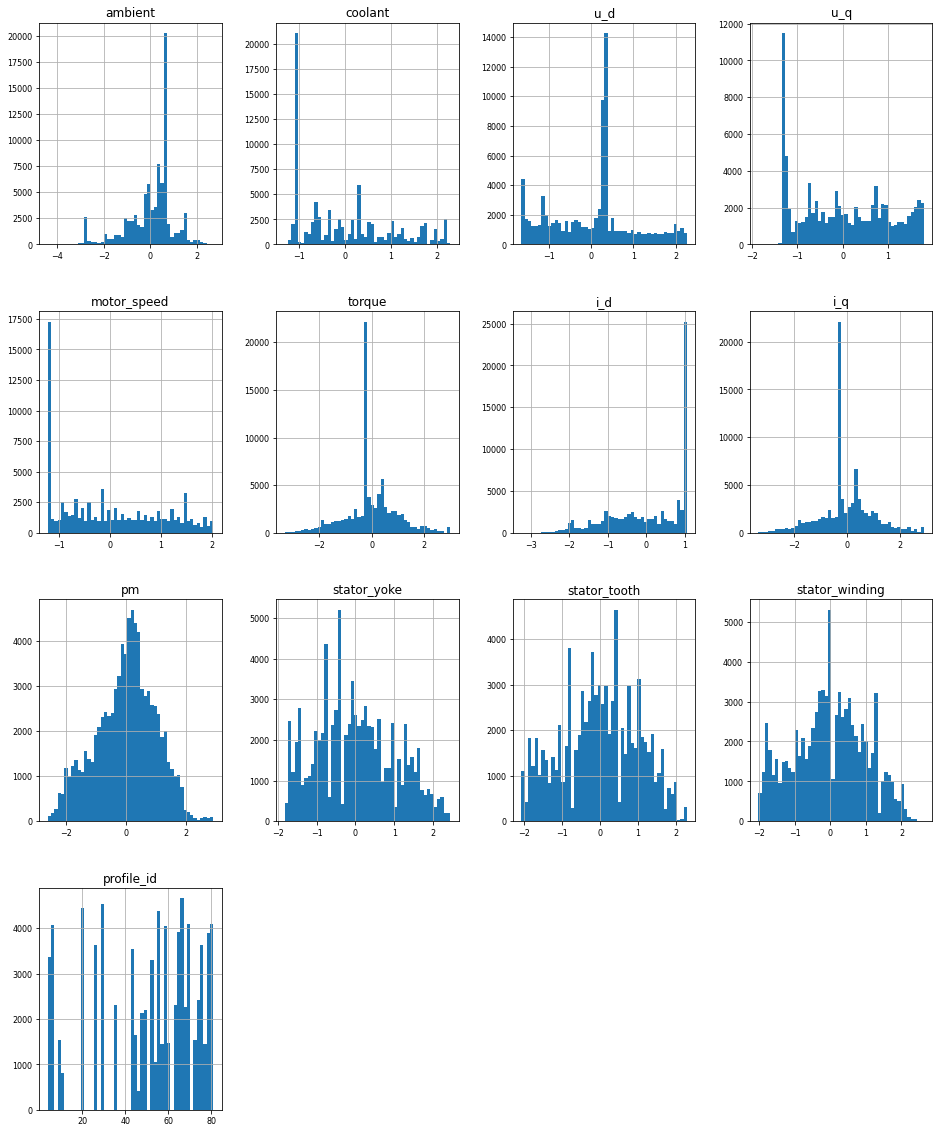

In [5]:
print(list(set(df_main.dtypes.tolist())))
df_num = df_main.select_dtypes(include=['float64', 'int64'])
df_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)

Use correlation to see feature importance, gini score seems suitible for discrete valuse and not suitable for continuous values like this one.

In [6]:
X = df_main.drop(columns=['pm', 'stator_yoke', 'stator_tooth', 'stator_winding', 'profile_id'])

for feature in target_feature_list:
  X[feature] = df_main[feature]
  df_num_corr = X.corr()[feature]
  golden_features_list = df_num_corr[abs(df_num_corr) > 0.1].sort_values(ascending=True)
  print("There is {} correlated values with feature {}:\n{}"
        .format(len(golden_features_list), feature, golden_features_list))
  X = X.drop(columns=[feature])

There is 8 correlated values with feature pm:
i_d           -0.289964
i_q           -0.115712
torque        -0.102938
u_q            0.110267
motor_speed    0.334369
coolant        0.449906
ambient        0.561538
pm             1.000000
Name: pm, dtype: float64
There is 8 correlated values with feature stator_yoke:
i_d           -0.178884
i_q           -0.119077
torque        -0.111560
u_q            0.108873
motor_speed    0.186349
ambient        0.468044
coolant        0.881382
stator_yoke    1.000000
Name: stator_yoke, dtype: float64
There is 6 correlated values with feature stator_tooth:
i_d            -0.380170
u_q             0.154517
motor_speed     0.331926
ambient         0.431389
coolant         0.705098
stator_tooth    1.000000
Name: stator_tooth, dtype: float64
There is 7 correlated values with feature stator_winding:
i_d              -0.530414
u_d              -0.128440
u_q               0.133090
ambient           0.343234
motor_speed       0.387311
coolant           0.52

Where we can see <br />
Coolant motor_speed ambient i_d are most important features correlated to target features, profile_id is least correlated

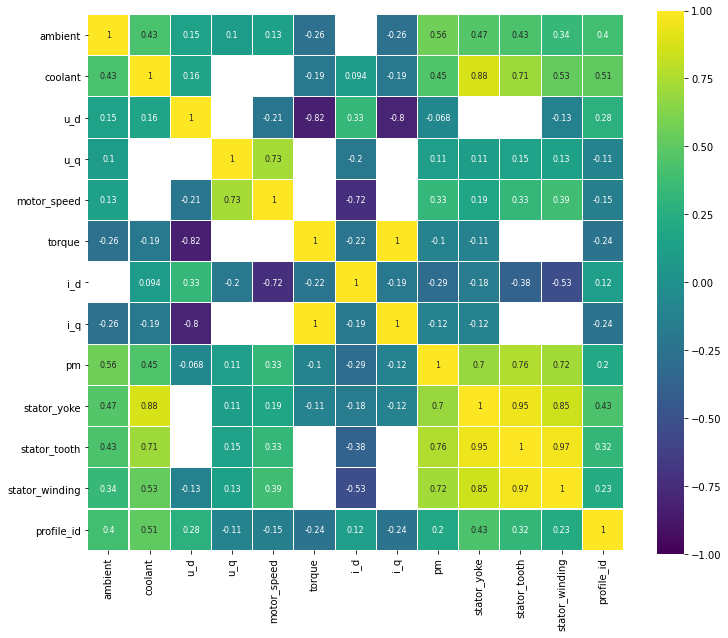

In [7]:
# Features correlations
#
# We already examined AcresBurned correlations
# We use heatmap to better understand correlations among features
# Shown with the abslute correlation > 0.06
corr = df_main.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr[(corr >= 0.06) | (corr <= -0.06)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Use elbow method to determine cluster number N <br />

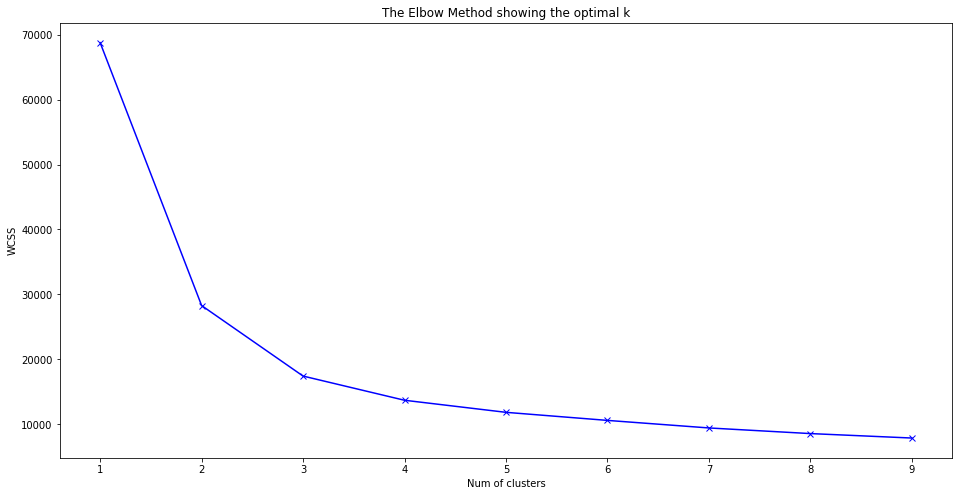

In [8]:
from sklearn.cluster import KMeans

wcss = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeanModel.fit(df_cluster)
    wcss.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Num of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From elblow methos, we use cluster number N=3. <br />
Use Spectral clusting:

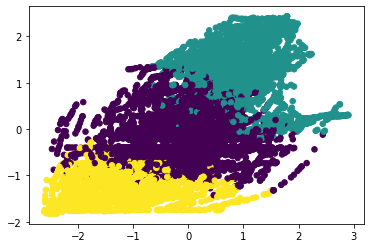

In [9]:
from sklearn.cluster import SpectralClustering

X = df_cluster.to_numpy()

spc_cluster = SpectralClustering(n_clusters=3,
         assign_labels="discretize",
         random_state=0)
spc_cluster.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=spc_cluster.labels_, s=30, cmap='viridis')
plt.show()

Use KMean clustering:

In [10]:
from sklearn.cluster import KMeans

n_clusters = 3
X = df_cluster.to_numpy()
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

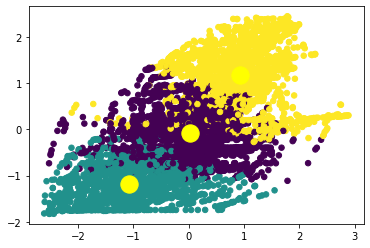

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.show()

Use Gaussian Mixture clustering:

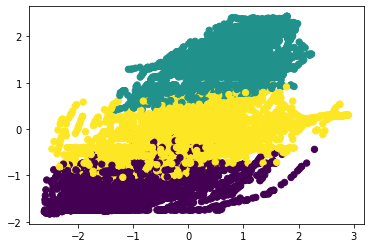

In [11]:
from sklearn import mixture
# Select covariance_type as tied since
# all components seem sharing the same general covariance matrix
gmm = mixture.GaussianMixture(n_components=3, covariance_type='tied', random_state=0).fit(X)
gmm_labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, s=40, cmap='viridis')

Use Birch clustering

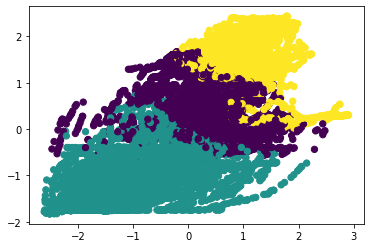

In [12]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=3).fit(X)
brc_labels = brc.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=brc_labels, s=40, cmap='viridis')

Use Agglomerative Clustering

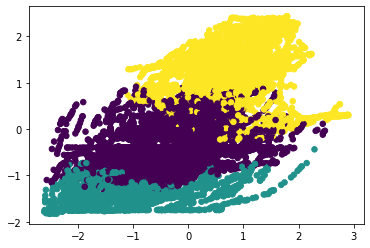

In [13]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X)
plt.scatter(X[:, 0], X[:, 1], c=agg.labels_, s=30, cmap='viridis')

We can see KMeans and Spectral have similar clustering results, and Gaussian and Birch have similar clustering results on our dataset.

In [14]:
df_cluster['y_kmean'] = kmeans.labels_
df_cluster['y_gmm'] = gmm_labels
df_cluster['y_spec'] = spc_cluster.labels_
df_cluster['y_agg'] = agg.labels_
df_cluster['y_brc'] = brc_labels
df_cluster.sample(n=30)

,pm,stator_yoke,stator_tooth,stator_winding,y_kmean,y_gmm,y_spec,y_agg,y_brc
78640,1.275367,0.896277,0.880789,0.917403,2,2,1,2,0
70267,-1.583228,-1.439684,-1.536846,-1.558916,1,0,2,1,1
26412,1.525602,1.411903,1.535082,1.545651,2,1,1,2,2
59785,1.366359,0.145697,0.419000,0.327955,0,2,0,0,0
57845,-2.092460,-1.139568,-1.333322,-1.287459,1,0,2,1,1
53731,0.942730,0.472449,0.324301,0.144339,0,2,0,0,0
33305,0.113682,-0.059414,-0.160923,-0.275138,0,2,0,0,0
10791,-0.562700,-1.220090,-1.435144,-1.453140,1,0,2,0,1
41387,0.438300,0.472403,0.636549,0.973568,2,2,1,0,0
78349,0.924861,-0.195787,0.461857,0.962610,0,2,0,2,0


What the clustering results represent, take KMean for example: <br />
Cluster 0 represents the medium tempratures <br />
Cluster 1 represents the low tempratures <br />
Cluster 2 represents the high tempratures <br />
<br />

Gaussian and Birch clustering results cannot reprent this, so they should not be used in this dataset clutering.

Compare the performance of clustering methods on this data set <br />
Take KMeans as baseline since we dont have real true labels available<br />
Measures the similarity of the two assignments, ignoring permutations

In [24]:
from sklearn import metrics

metrics.adjusted_rand_score(kmeans.labels_, gmm_labels)

0.5078915179607076

In [25]:
metrics.adjusted_rand_score(kmeans.labels_, brc_labels)

0.3737272389115344

In [26]:
metrics.adjusted_rand_score(kmeans.labels_, agg.labels_)

0.5874963374211676

In [27]:
metrics.adjusted_rand_score(kmeans.labels_, spc_cluster.labels_)

0.7896226826524199

Where we can see Spectral has more similar clustering results as KMeans on this dataset

Calculate silhouette_score to see the cohesion of the cluster results:

In [28]:
metrics.silhouette_score(X, kmeans.labels_)

0.4184924662645207

In [29]:
metrics.silhouette_score(X, gmm_labels)

0.31694032974981734

In [21]:
metrics.silhouette_score(X, brc_labels)

0.352455199834036

In [22]:
metrics.silhouette_score(X, agg.labels_)

0.37933043964506974

In [23]:
metrics.silhouette_score(X, spc_cluster.labels_)

0.4186244968247311

We can see the KMeans and Spectral get the better score, which means they perform better in terms of clustering cohesion.